In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
chunksize=100000
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string

In [2]:
# Custom date parser function
date_parser = lambda x: pd.to_datetime(x, unit='s')

# tags
all_tags = pd.DataFrame()  # initialize an empty dataframe
for index, chunk in enumerate(pd.read_csv('../ml-20m/tags.csv',
                         dtype={'userId': str, 'movieId': str, "tag": str, 'timestamp': int},
                         chunksize=chunksize,
                         parse_dates=['timestamp'],
                         date_parser=date_parser
                         )):
    # Perform operations on the chunk
    # processed_chunk = chunk[chunk['column_name'] > 0]  # Example operation
    all_tags = pd.concat([all_tags, chunk])
    print(f"Chunk {index} loaded")
print("Ratings dataset loaded")

/var/folders/55/xtgthnr12lz2b2j6l0pqj7zm0459s6/T/ipykernel_24147/1552740927.py:6: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  for index, chunk in enumerate(pd.read_csv('../ml-20m/tags.csv',


Chunk 0 loaded
Chunk 1 loaded
Chunk 2 loaded
Chunk 3 loaded
Chunk 4 loaded
Ratings dataset loaded


In [3]:
def clean_text(text):
    if pd.isna(text):
        return ''
    # Convert to lowercase
    text = text.lower()
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove extra whitespace
    text = text.strip()
    # Remove multiple spaces
    text = re.sub(r'\s+', ' ', text)
    # Remove text that is less than 3 characters
    if len(text) < 3:
        return ''
    return text

# Apply the cleaning function to the 'tag' column
all_tags['cleaned_tag'] = all_tags['tag'].apply(clean_text)

# Alternatively, you can use the drop method
all_tags = all_tags.drop(all_tags[all_tags['cleaned_tag'] == ''].index)


# Display the first few rows to verify the cleaning
print(all_tags.head())

  userId movieId            tag           timestamp    cleaned_tag
0     18    4141    Mark Waters 2009-04-24 18:19:40    mark waters
1     65     208      dark hero 2013-05-10 01:41:18      dark hero
2     65     353      dark hero 2013-05-10 01:41:19      dark hero
3     65     521  noir thriller 2013-05-10 01:39:43  noir thriller
4     65     592      dark hero 2013-05-10 01:41:18      dark hero


In [4]:

print(all_tags.info())

<class 'pandas.core.frame.DataFrame'>
Index: 458662 entries, 0 to 465563
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   userId       458662 non-null  object        
 1   movieId      458662 non-null  object        
 2   tag          458662 non-null  object        
 3   timestamp    458662 non-null  datetime64[ns]
 4   cleaned_tag  458662 non-null  object        
dtypes: datetime64[ns](1), object(4)
memory usage: 21.0+ MB
None


This is the full tags table with 465,564 rows. Nexxt, this will be filtered out based on the id of the movie and user. This way it will only have tags that are apart of the initial ratings subset. First, the end ratings table will be imported 

In [5]:
# Custom date parser function
date_parser = lambda x: pd.to_datetime(x, unit='s')

# movies
combined_movies_ratings = pd.DataFrame()  # initialize an empty dataframe
for index, chunk in enumerate(pd.read_csv('../samples/combined_movies_ratings.csv',
                                          dtype={"userId":str, 'movieId': str,},
                         chunksize=chunksize,
                         )):
    # Perform operations on the chunk
    # processed_chunk = chunk[chunk['column_name'] > 0]  # Example operation
    combined_movies_ratings = pd.concat([combined_movies_ratings, chunk])
    print(f"Chunk {index} loaded")
print("ratings dataset loaded")

Chunk 0 loaded
Chunk 1 loaded
Chunk 2 loaded
Chunk 3 loaded
Chunk 4 loaded
Chunk 5 loaded
Chunk 6 loaded
Chunk 7 loaded
Chunk 8 loaded
Chunk 9 loaded
Chunk 10 loaded
Chunk 11 loaded
Chunk 12 loaded
Chunk 13 loaded
Chunk 14 loaded
ratings dataset loaded


Next, I will create a new tags dataframe and filter out the unnecessary data

In [6]:

# Extract the movieIds from the ratings_sample DataFrame
user_movie_ids_to_keep = combined_movies_ratings[['movieId', "userId"]]

# Filter the movies DataFrame to only include movies with movieIds in user_movie_ids_to_keep
tags = pd.merge(all_tags, user_movie_ids_to_keep, on=['movieId', 'userId'], how='inner')

print(tags.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30023 entries, 0 to 30022
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   userId       30023 non-null  object        
 1   movieId      30023 non-null  object        
 2   tag          30023 non-null  object        
 3   timestamp    30023 non-null  datetime64[ns]
 4   cleaned_tag  30023 non-null  object        
dtypes: datetime64[ns](1), object(4)
memory usage: 1.1+ MB
None


We have significantly reduced the size of the tags table; from 465,564 to 30,023. This is a significantly smaller amount than the 2 million in the ratings dataset. But may be significant enough to do soime initial exploration with

Now that the data has been cleaned and filtered, I will explore the tags table

cleaned_tag
erlend's dvds        323
atmospheric          240
sci-fi               240
classic              204
based on a book      203
surreal              192
twist ending         189
quirky               182
comedy               178
action               166
dystopia             152
dark comedy          149
stylized             134
memasa's movies      133
psychology           132
disturbing           129
horror               126
social commentary    123
funny                123
on dvr               122
thought-provoking    121
nudity (topless)     115
dark                 114
romance              113
cult film            106
fantasy              104
time travel          102
drama                100
black comedy          99
violence              97
Name: count, dtype: int64


/var/folders/55/xtgthnr12lz2b2j6l0pqj7zm0459s6/T/ipykernel_24147/1526492541.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_1_tags.values, y=top_1_tags.index, palette="hls")


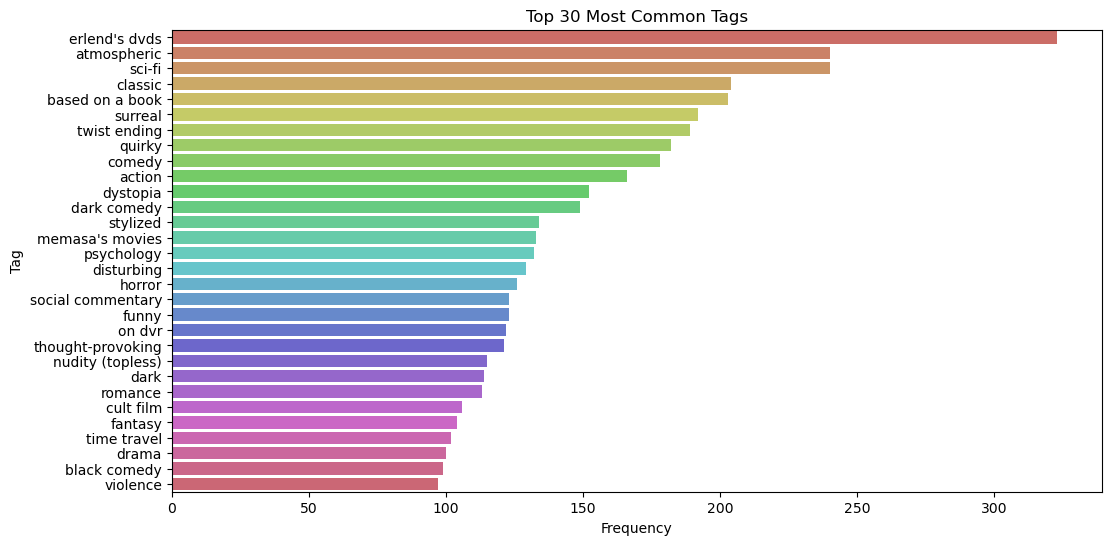

In [7]:
# Count the frequency of each cleaned tag
tag_counts = tags['cleaned_tag'].value_counts()

# Display the top 1% most common tags
top_1_tags = tag_counts.head(30)
print(top_1_tags)

# Plot the top 30 most common tags
plt.figure(figsize=(12, 6))
sns.barplot(x=top_1_tags.values, y=top_1_tags.index, palette="hls")
plt.title('Top 30 Most Common Tags')
plt.xlabel('Frequency')
plt.ylabel('Tag')
plt.show()

this chart shows that some of the tags are simple one word descriptions of the movie. SOme of the tags are less usefull though, such as the top tag "erland's dvd". It's not as asimple as removing any tags with more than one word though, as some tags have more than one word eg "based on a book"

count    30023.000000
mean        10.909170
std          5.600349
min          3.000000
25%          7.000000
50%         10.000000
75%         13.000000
max        149.000000
Name: tag_length, dtype: float64


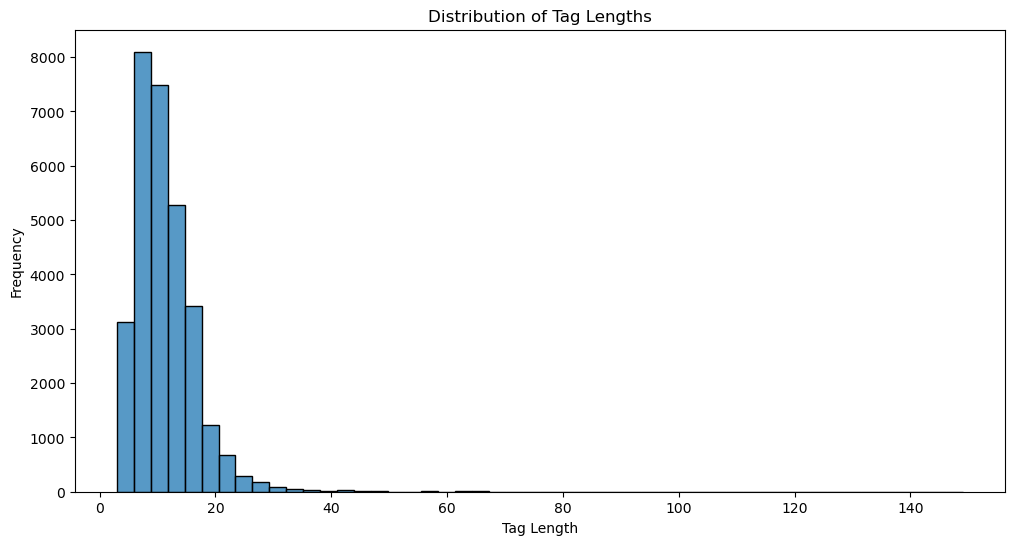

In [8]:
# Calculate the length of each cleaned tag
tags['tag_length'] = tags['cleaned_tag'].apply(len)

print(tags['tag_length'].describe())

# Display the distribution of tag lengths
plt.figure(figsize=(12, 6))
sns.histplot(tags['tag_length'], bins=50)
plt.title('Distribution of Tag Lengths')
plt.xlabel('Tag Length')
plt.ylabel('Frequency')
plt.show()

This chart shows waht was tocuhed on previously, while many tags are small in size, there are some longer lenght tags that may not be useful, and could be cleaned form the table.

<class 'pandas.core.frame.DataFrame'>
Index: 28302 entries, 0 to 30022
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   userId       28302 non-null  object        
 1   movieId      28302 non-null  object        
 2   tag          28302 non-null  object        
 3   timestamp    28302 non-null  datetime64[ns]
 4   cleaned_tag  28302 non-null  object        
 5   tag_length   28302 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 1.5+ MB
None


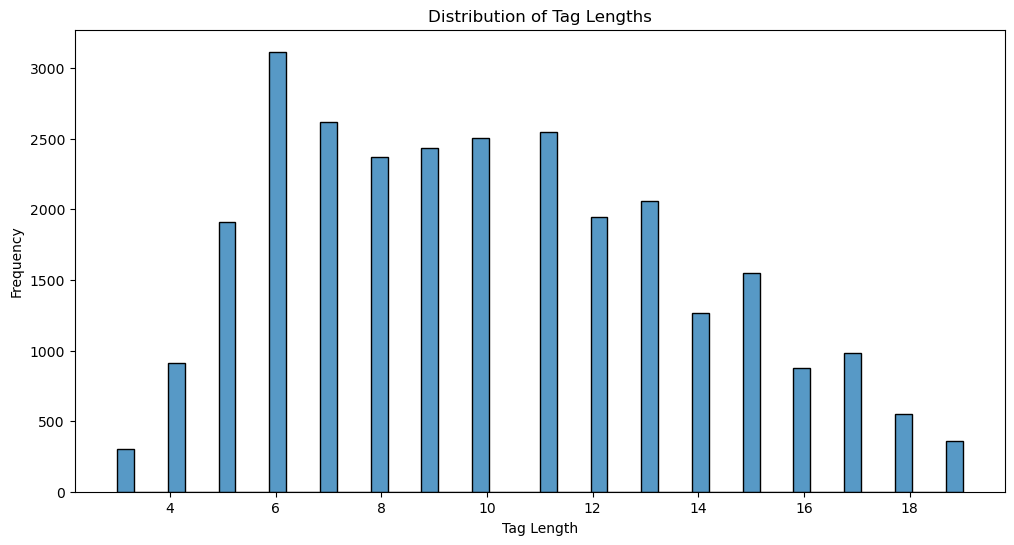

In [9]:
# Calculate the length of each cleaned tag
tags['tag_length'] = tags['cleaned_tag'].apply(len)

print(tags[tags['tag_length']<20].info())

# Display the distribution of tag lengths
plt.figure(figsize=(12, 6))
sns.histplot(tags[tags['tag_length']<20]["tag_length"], bins=50)
plt.title('Distribution of Tag Lengths')
plt.xlabel('Tag Length')
plt.ylabel('Frequency')
plt.show()

This distribution looks better cleaner and will be better for predictive modeling. 

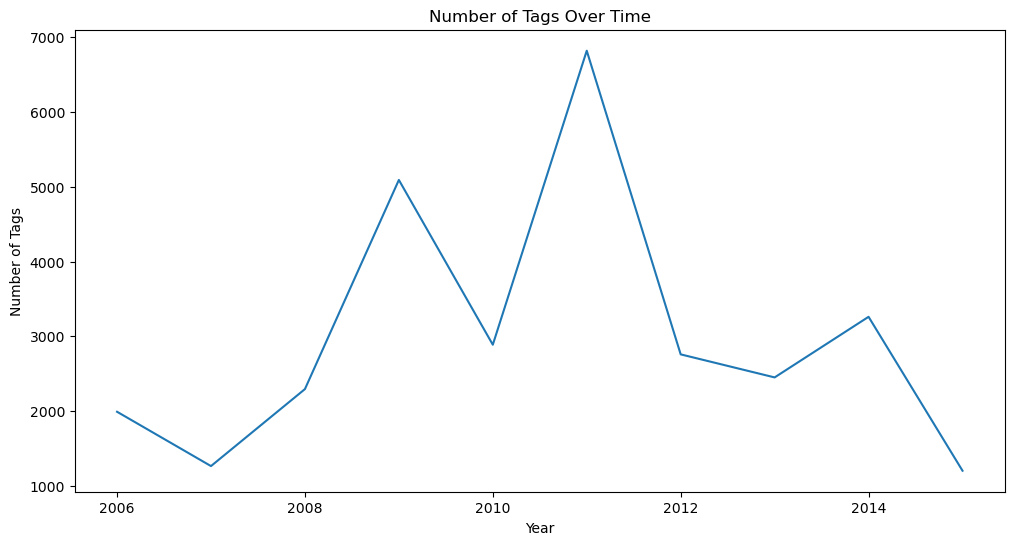

In [10]:
# Convert the timestamp to a more readable format
tags['year'] = tags['timestamp'].dt.year

# Count the number of tags per year
tags_per_year = tags['year'].value_counts()

# Plot the number of tags per year
plt.figure(figsize=(12, 6))
sns.lineplot(x=tags_per_year.index, y=tags_per_year.values)
plt.title('Number of Tags Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Tags')
plt.show()

This chart shows that the most tags were added in 2011 and the years before and after. Next, the users who provided the he most tags will be shown. This will help to see if there are any users who have created a large number of tags

count     616.000000
mean       48.738636
std       263.165109
min         1.000000
25%         1.750000
50%         4.500000
75%        20.250000
max      5210.000000
Name: count, dtype: float64


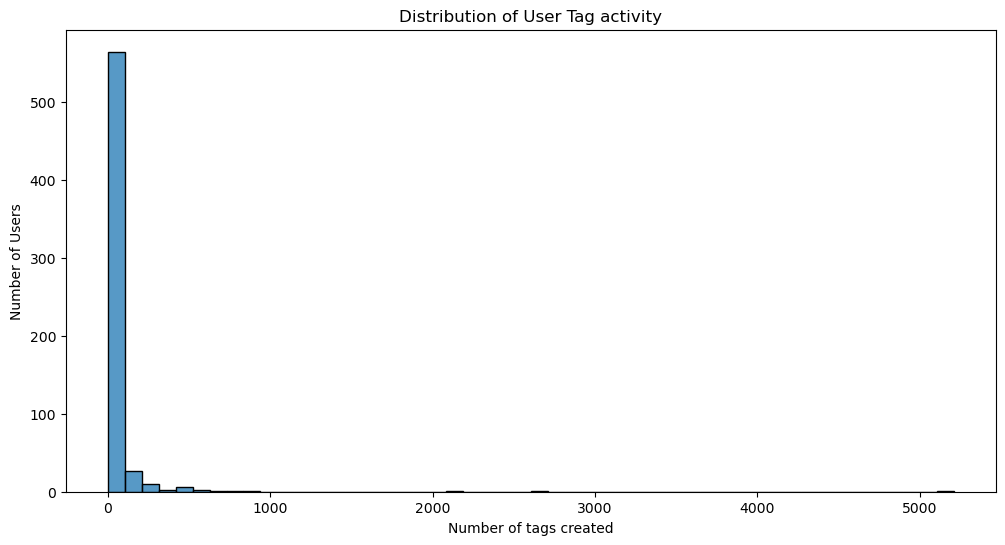

In [11]:
# Count the number of tags per user
tags_per_user = tags['userId'].value_counts()

print(tags_per_user.describe())
plt.figure(figsize=(12, 6))
sns.histplot(x=tags_per_user, bins=50)
plt.title('Distribution of User Tag activity')
plt.xlabel('Number of tags created')
plt.ylabel('Number of Users')
plt.show()

This chart shows a highly skewed distribution of tags per user. One user has 5210 values and is responsable for almost 20% of the total table. The median user tag count is 4, so the user with a  large count is an outlier. But this data could still be usefull in a content based filtering system. As the tag data will only be used in the content based filter, this will be left in and used.  

count    3545.000000
mean        8.469111
std        12.705255
min         1.000000
25%         2.000000
50%         4.000000
75%        10.000000
max       168.000000
Name: count, dtype: float64


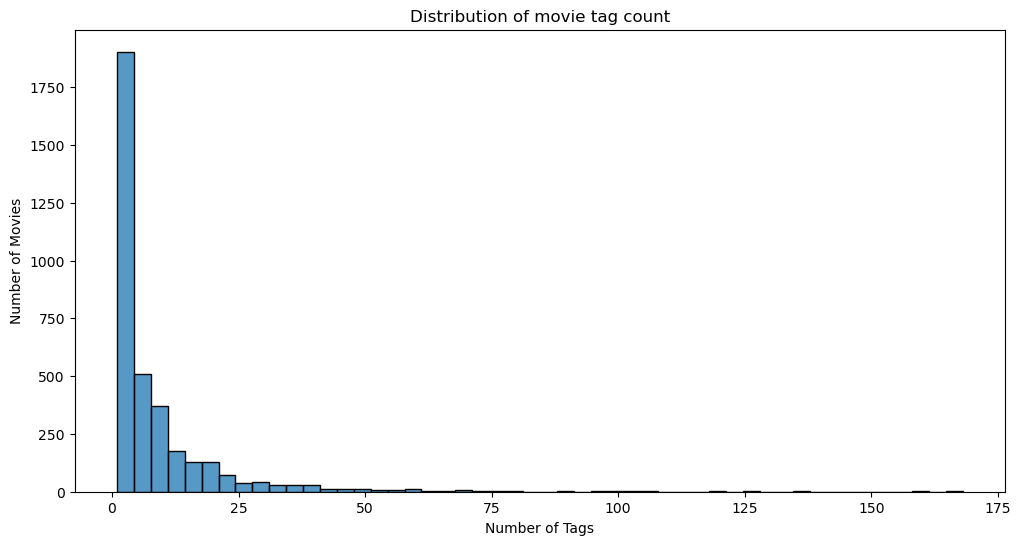

In [12]:
# Count the number of tags per movie
tags_per_movie = tags['movieId'].value_counts()

print(tags_per_movie.describe())

# Plot the top 20 movies with the most tags
plt.figure(figsize=(12, 6))
sns.histplot(x=tags_per_movie.values, bins=50)
plt.title('Distribution of movie tag count')
plt.xlabel('Number of Tags')
plt.ylabel('Number of Movies')
plt.show()

the same distribution occurs in the number of tags added for each movie. Most movies have less than 25 tags. The maximum number of tags is 168 tags

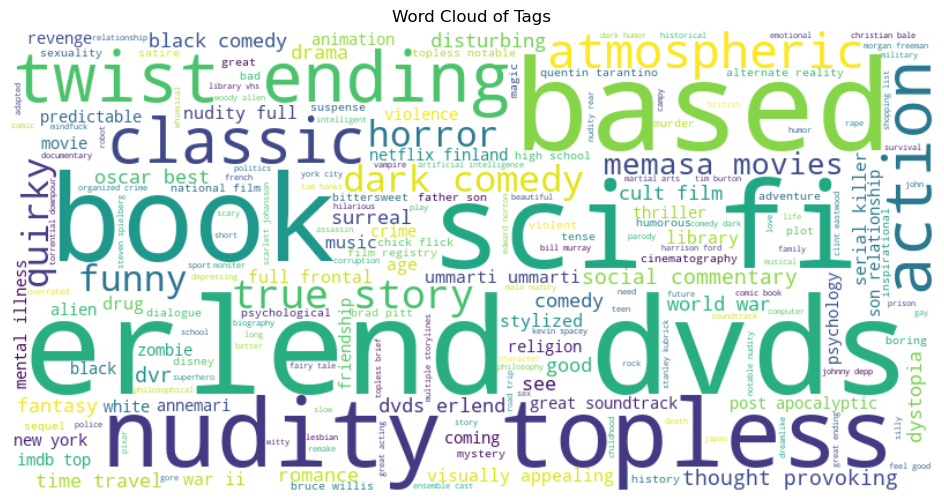

In [13]:
from wordcloud import WordCloud, STOPWORDS

# Combine all cleaned tags into a single string
all_tags = ' '.join(tags['cleaned_tag'])
stopwords = set(STOPWORDS)

# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords = stopwords,).generate(all_tags)

# Display the word cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Tags')
plt.show()

An interesting visual of some lof the most reoccuring tags in the dataset

Now that this table has been explored it will be exported as is, so it can be combined with other exploration tables

In [16]:
tags = tags.rename(columns={
    'year': 'tag_year',
    'timestamp': 'tag_timestamp'
})

# Merge the movies dataset with the ratings dataset on 'movieId'
combined_df = pd.merge(combined_movies_ratings, tags, on=['movieId', 'userId'], how='left')

combined_df['tag'] = combined_df['tag'].fillna('')
combined_df['tag_timestamp'] = combined_df['tag_timestamp'].fillna('')
combined_df['cleaned_tag'] = combined_df['cleaned_tag'].fillna('')
combined_df['tag_length'] = combined_df['tag_length'].fillna('')
combined_df['tag_year'] = combined_df['tag_year'].fillna('')

# Export the combined dataset to a CSV file
combined_df.to_csv('../samples/combined_movies_ratings_tags.csv', index=False)

In [17]:
non_empty_count = (combined_df['cleaned_tag'] != '').sum()

print(f"Number of non-empty 'cleaned_tag' entries: {non_empty_count}")

Number of non-empty 'cleaned_tag' entries: 30023
